In [60]:
# this ai_utils version work only keras package (new 1.1.4 not is in pypi)
# from ai_utils.metrics import R_squared, fac2, pearson_r
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from livelossplot.tf_keras import PlotLossesCallback
from sklearn.metrics import classification_report
from tensorflow.keras import backend as K
from sklearn import preprocessing
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import numpy as np
import joblib

## 1 - Global variables

In [61]:
# Global variables
ARGS = {
    "dataset_t": "dataset/outer.csv",
    "headers": "dataset/header.csv",
}

In [62]:
# Load headers of dataset
HEADERS = pd.read_csv(ARGS["headers"], header=None).iloc[0]
display(HEADERS)

0     datetime
1           co
2          Lat
3         Long
4          day
5        month
6         year
7         hour
8          gmt
9          no2
10          o3
11        pm10
12        pm25
13         so2
Name: 0, dtype: object

## 2 - Functions

### Third party functions [ai_utils](https://github.com/rcluan/ai_utils/blob/master/ai_utils/metrics/__init__.py)

In [63]:
def R_squared(y_true, y_pred):
    y_true_mean = y_true.mean()
    y_pred_mean = y_pred.mean()

    sum_num = np.sum((y_pred-y_pred_mean)*y_true)
    numerator = np.square(sum_num)

    ypm_square = np.square(y_pred - y_pred_mean)
    ytm_square = np.square(y_true - y_true_mean)
    denominator = np.sum(ypm_square) * np.sum(ytm_square)
    
    return numerator/denominator

In [64]:
def fac2(y_true, y_pred, to_numpy=False):
    min_ = 0.5
    max_ = 2

    division = tf.divide(y_pred, y_true)

    greater_min = tf.greater_equal(division, min_)
    less_max = tf.less_equal(division, max_)

    res = tf.equal(greater_min, less_max)
    res = tf.cast(res, tf.float32)

    fac_2 = tf.reduce_mean(res)

    return K.get_value(fac_2) if to_numpy else fac_2


In [65]:
def pearson_r(y_true, y_pred):
    y_true_mean = y_true.mean()
    y_pred_mean = y_pred.mean()

    diff_yt = y_true - y_true_mean
    diff_yp = y_pred - y_pred_mean

    numerator = np.sum((diff_yt) * (diff_yp))
    denominator = np.sqrt(np.sum(np.square(diff_yt))) * np.sqrt(np.sum(np.square(diff_yp)))

    return numerator/denominator

---

In [66]:
# Function for multi plot
def _mplot(data_frame, x_values=None, x_title=None, w=16, h=12):
    # Get column count
    length = data_frame.shape[1]

    if x_values:
        x_values = data_frame.loc[:, x_values]
    else:
        x_values = data_frame.index
        
    _, axs = plt.subplots(length, 1, figsize=(w,h), sharex=True)
    for idx, column in enumerate(data_frame):
        axs[idx].plot(x_values, data_frame.loc[:, column], label=column)
        axs[idx].set_title(column)
        axs[idx].set_ylabel(column)
        axs[idx].legend()

    # adds space between plots
    plt.tight_layout()
    plt.xlabel(x_title)
    plt.show()

In [67]:
# Function for plot true and pred values
def _plot(true, pred, w=16, h=12, title="Previsão da velocidade média em Mucuri"):
    size = range(len(true))
    plt.figure(figsize=(w,h))
    plt.style.use("ggplot")
    plt.plot(size, true, linestyle="--", label="Anemômetro")
    plt.plot(size, pred, label="Rede Neural Artificial")
    plt.title(title)
    plt.xlabel("Tempo")
    plt.ylabel("Velocidade do vento (m/s)")
    plt.legend()
    plt.show()

In [68]:
# Function for show describe of dataset
def _describe(data_frame):
    def _apply(header, column):
        _max = column.max()
        _min = column.min()
        _count = column.count()

        return {
            "header": header,
            "max": _max,
            "min": _min,
            "mean": column.mean(),
            "median": column.median(),
            "1-quartile": column.quantile(0.25),
            "3-quartile": column.quantile(0.75),
            "var": column.var(),
            "std": column.std(),
            "mad": column.mad(),
            "amp": _max - _min,
            "rms": sum((column.pow(2)) / (_count)) ** (1 / 2),
            "kurtosis": column.kurtosis(),
            "skew": column.skew(),
            "count": _count,
            "nans": np.where(np.isnan(column))
        }

    headers = data_frame.columns
    return pd.DataFrame(
        [_apply(_, data_frame.loc[:, _]) for _ in headers]
    ).set_index("header")

In [69]:
# Function for evaluating prediction
def _evaluate(y_true, y_pred, index):
    return pd.DataFrame([{
        "r_squared": R_squared(y_true, y_pred),
        "fac_2": fac2(y_true, y_pred, to_numpy=True),
        "pearson_r": pearson_r(y_true, y_pred),
        "mae": mae(y_true, y_pred),
        "mse": mse(y_true, y_pred),
        "min_error": np.amin(np.absolute(y_true - y_pred)),
        "max_error": np.amax(np.absolute(y_true - y_pred)),
    }], index=[index])

---

## 3 - Training and Validation

### 3.1 - Load and decription of datas

In [77]:
# Load train datas
df_t = pd.read_csv(
    ARGS["dataset_t"], header=None, names=HEADERS, parse_dates=["datetime"], index_col="datetime"
)
df_t = df_t.drop("gmt", axis=1)
df_t = df_t.dropna()
df_t = df_t.sort_values("datetime")
display(df_t)

array([34.0669 , 34.06643])

In [71]:
# Sow train data description (exists one nan value in temperatura = line 351)
_describe(df_t.loc[:, "so2":])

,max,min,mean,median,1-quartile,3-quartile,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,
so2,0.018,0.0,0.000286,0.0,0.0,0.001,3.082097e-07,0.000555,0.00042,0.018,0.000624,164.407278,7.046606,8957,"([],)"


---

### 3.2 - Split and normalize of datas

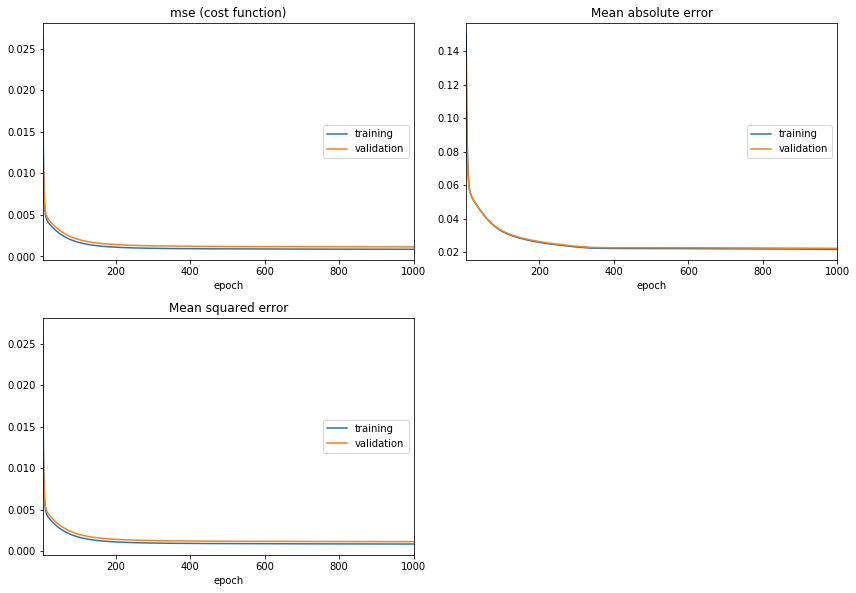

mse (cost function):
training   (min:    0.001, max:    0.077, cur:    0.001)
validation (min:    0.001, max:    0.057, cur:    0.001)

Mean absolute error:
training   (min:    0.022, max:    0.256, cur:    0.022)
validation (min:    0.022, max:    0.220, cur:    0.022)

Mean squared error:
training   (min:    0.001, max:    0.077, cur:    0.001)
validation (min:    0.001, max:    0.057, cur:    0.001)
6717/6717 [==============================] - 1s 139us/sample - loss: 8.5966e-04 - mean_absolute_error: 0.0216 - mean_squared_error: 8.5966e-04 - val_loss: 0.0011 - val_mean_absolute_error: 0.0222 - val_mean_squared_error: 0.0011


In [80]:
# 0 co 7 no2 8 o3 9 pm10 10 pm25 11 so2
targets = [0, 7, 8, 9, 10, 11]
models = []
for i in targets:
    # Dataset for execution of the train and validation
    x = df_t.iloc[:-1]
    y = df_t.iloc[1:, i]

    # Partition the data into training and testing splits using 75% of
    # the data for training and the remaining 25% for testing
    (x_train, x_test, y_train, y_test) = train_test_split(
        x, y, test_size=0.25, random_state=42
    )

    # Normalize vector x
    x_scaler = preprocessing.MinMaxScaler()
    x_train = x_scaler.fit_transform(x_train)
    x_test = x_scaler.transform(x_test)
    # save scale of x
    joblib.dump(x_scaler, f"{i}_x.joblib")

    # Normalize vector y
    y_scaler = preprocessing.MinMaxScaler()
    y_train = y_scaler.fit_transform(y_train.values.reshape(-1, 1))
    y_test = y_scaler.transform(y_test.values.reshape(-1, 1))
    # save scale of x
    joblib.dump(y_scaler, f"{i}_x.joblib")

    # Define the 9-9-6-1 architecture using tf.keras
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(12, input_shape=(12,), activation="relu"))
    model.add(tf.keras.layers.Dense(12, activation="relu"))
    model.add(tf.keras.layers.Dense(6, activation="relu"))
    model.add(tf.keras.layers.Dense(1, activation="linear"))

    # Initialize our initial learning rate and # of epochs to train for
    INIT_LR = 0.001
    EPOCHS = 1000
    BATCH_SIZE = 128

    # Compile the model using SGD as our optimizer, mae and mse
    opt = tf.keras.optimizers.SGD(lr=INIT_LR)
    model.compile(loss="mse", optimizer=opt, metrics=["mae", "mse"])

    # Train the neural network
    H = model.fit(
        x_train,
        y_train,
        validation_data=(x_test, y_test),
        epochs=EPOCHS,
        batch_size=BATCH_SIZE,
        callbacks=[
            EarlyStopping(patience=15),
            PlotLossesCallback()
        ]
    )
    
    models.append(model)
    model.save(f"{i}_model")

---

In [120]:
# Evaluate the model (MSE and MAE)
legends = ["co", "no2", "o3", "pm10", "pm25", "so2"]
for i in range(len(models)):
#     scores = models[i].evaluate(x_test, y_test)
    print(f"{legends[i]}")
    for s in range(1, len(scores)):
        print(f"{models[i].metrics_names[s]}: {scores[s]}")

co
mean_absolute_error: 0.02223207801580429
mean_squared_error: 0.0011453396873548627
no2
mean_absolute_error: 0.02223207801580429
mean_squared_error: 0.0011453396873548627
o3
mean_absolute_error: 0.02223207801580429
mean_squared_error: 0.0011453396873548627
pm10
mean_absolute_error: 0.02223207801580429
mean_squared_error: 0.0011453396873548627
pm25
mean_absolute_error: 0.02223207801580429
mean_squared_error: 0.0011453396873548627
so2
mean_absolute_error: 0.02223207801580429
mean_squared_error: 0.0011453396873548627


---

## 4 - Forecasting and Evaluation

### 4.1 - Load and decription of datas

In [88]:
# Load pred datas
df = df_t.copy()
display(df)

,co,Lat,Long,day,month,year,hour,no2,o3,pm10,pm25,so2
datetime,,,,,,,,,,,,
2016-11-15 20:00:00,0.71,34.06690,-118.24170,15,11,2016,20,0.060,0.027,78.0,45.0,0.001
2016-11-16 00:00:00,0.55,34.06690,-118.24170,16,11,2016,0,0.037,0.029,59.0,27.0,0.001
2016-11-16 01:00:00,0.57,34.06690,-118.24170,16,11,2016,1,0.040,0.019,57.0,22.0,0.001
2016-11-16 15:00:00,1.02,34.06690,-118.24170,16,11,2016,15,0.034,0.001,78.0,32.0,0.001
2016-11-16 16:00:00,0.53,34.06690,-118.24170,16,11,2016,16,0.027,0.007,67.0,37.0,0.000
...,...,...,...,...,...,...,...,...,...,...,...,...
2019-06-06 11:00:00,0.23,34.06643,-118.22675,6,6,2019,11,0.009,0.026,20.0,17.0,0.000
2019-06-06 12:00:00,0.23,34.06643,-118.22675,6,6,2019,12,0.011,0.025,24.0,14.0,0.000
2019-06-06 13:00:00,0.23,34.06643,-118.22675,6,6,2019,13,0.010,0.027,27.0,17.0,0.000


In [89]:
# Sow train data description
_describe(df)

,max,min,mean,median,1-quartile,3-quartile,var,std,mad,amp,rms,kurtosis,skew,count,nans
header,,,,,,,,,,,,,,,
co,1.93000,0.00000,0.327864,0.25000,0.19000,0.39000,4.984677e-02,0.223264,0.157099,1.93000,0.396656,6.545874,2.243509,8957,"([],)"
Lat,34.06690,34.06643,34.066489,34.06643,34.06643,34.06643,2.418907e-08,0.000156,0.000103,0.00047,34.066489,3.135665,2.266046,8957,"([],)"
Long,-118.22675,-118.24170,-118.228621,-118.22675,-118.22675,-118.22675,2.447405e-05,0.004947,0.003274,0.01495,118.228621,3.135665,-2.266046,8957,"([],)"
day,31.00000,1.00000,15.829742,16.00000,8.00000,24.00000,7.977952e+01,8.931938,7.760899,30.00000,18.175570,-1.230473,-0.002857,8957,"([],)"
month,12.00000,1.00000,6.161103,6.00000,4.00000,8.00000,7.558791e+00,2.749325,2.239661,11.00000,6.746639,-0.499593,0.136401,8957,"([],)"
year,2019.00000,2016.00000,2017.906777,2018.00000,2017.00000,2018.00000,5.832022e-01,0.763677,0.609925,3.00000,2017.906921,-1.072925,0.065451,8957,"([],)"
hour,23.00000,0.00000,11.170035,11.00000,5.00000,17.00000,4.833565e+01,6.952384,6.047375,23.00000,13.156744,-1.224611,0.057923,8957,"([],)"
no2,0.07000,0.00100,0.015978,0.01300,0.00800,0.02200,1.071660e-04,0.010352,0.008274,0.06900,0.019038,0.956638,1.116402,8957,"([],)"
o3,0.11600,0.00000,0.027498,0.02700,0.01400,0.03900,3.179278e-04,0.017831,0.014360,0.11600,0.032772,0.298369,0.548758,8957,"([],)"


---

### 4.2 - Split and normalize of datas

In [93]:
targets = [0, 7, 8, 9, 10, 11]
for i in targets:
    # Dataset for execution of the prediction
    x_true = df.iloc[:-1]
    y_true = df.iloc[1:, i]

    # Normalize x_true
    x_true = x_scaler.transform(x_true)

    # Forecasting for 1 hour
    preds = model.predict(x_true)

    # Reverse normalization
    y_pred = y_scaler.inverse_transform(preds)

    # Plot true and forecasting values
#     _plot(y_true, y_pred)
    
    # Evaluate values for 1hour
    evaluate = _evaluate(
        y_true.values,
        y_pred[:,0],
        "1-hour(s)"
    )
    display(evaluate)

/opt/anaconda/envs/analytics/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:316: RuntimeWarning: divide by zero encountered in true_divide
  return x / y


,r_squared,fac_2,pearson_r,mae,mse,min_error,max_error
1-hour(s),0.00691,0.0,0.083124,0.327537,0.157105,0.000181,1.92837


,r_squared,fac_2,pearson_r,mae,mse,min_error,max_error
1-hour(s),0.000016,0.000223,-0.003958,0.015689,0.000353,0.000104,0.069575


/opt/anaconda/envs/analytics/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:316: RuntimeWarning: divide by zero encountered in true_divide
  return x / y


,r_squared,fac_2,pearson_r,mae,mse,min_error,max_error
1-hour(s),0.03346,0.005918,0.18292,0.027214,0.001057,0.000017,0.115412


/opt/anaconda/envs/analytics/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:316: RuntimeWarning: divide by zero encountered in true_divide
  return x / y


,r_squared,fac_2,pearson_r,mae,mse,min_error,max_error
1-hour(s),0.095364,0.0,0.308811,32.679595,1288.047702,0.000326,137.999576


/opt/anaconda/envs/analytics/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:316: RuntimeWarning: divide by zero encountered in true_divide
  return x / y


,r_squared,fac_2,pearson_r,mae,mse,min_error,max_error
1-hour(s),0.095879,0.0,0.309643,15.785335,325.225517,0.000182,98.999685


/opt/anaconda/envs/analytics/lib/python3.6/site-packages/tensorflow/python/ops/math_ops.py:316: RuntimeWarning: divide by zero encountered in true_divide
  return x / y


,r_squared,fac_2,pearson_r,mae,mse,min_error,max_error
1-hour(s),0.033599,0.031487,0.183302,0.000392,3.016542e-07,4.296228e-07,0.017497
